# P4 Milestone - Retweets prediction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
import math
import scipy as sp
from itertools import combinations 
import ast

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import*
from sklearn.model_selection import*
from sklearn.ensemble import*
from sklearn.metrics import*
from sklearn.preprocessing import*

In [3]:


Ego_dataset = "EgoALterProfiles.txt"
Ego_timelines = "EgoTimelines.txt"

timelines = pd.read_csv(Ego_timelines,compression=None,header=0,sep=None,error_bad_lines=False,delim_whitespace=False,na_values='\t',skipinitialspace=False, engine='python')

# Loading the data with regards to set delimiter on tab.
profiles = pd.read_csv(Ego_dataset, delimiter="\t", error_bad_lines=False)

## Processing Part

### *Adding follower count to timelines*

In [4]:
# add follower count in timeline
followers = np.zeros(len(timelines))
friends = np.zeros(len(timelines))
p = 0
profiles3 = profiles.loc[profiles.IsEgo == True].set_index('ID')

for i in (range(len(timelines))):
    if timelines['egoID'].iloc[i] == profiles3.index[p]:
        followers[i] = profiles3.followers_count.iloc[p]
        friends[i] = profiles3.friends_count.iloc[p]
    else:
        followers[i] = profiles3.followers_count.iloc[p+1]
        friends[i] = profiles3.friends_count.iloc[p+1]
        p+=1

In [5]:
timelines['follower_count'] = followers
timelines['friends_count'] = friends

### *Visualization of different parameters influence on retweet count*

#### <font color='purple'>1) Function of follower count and friends count </font> 

In [6]:
# we do not take into account reply, mention and retweet

timelines = timelines.fillna(0)
timelines2 = timelines.loc[timelines.retweeted_userid==0]
timelines3 = timelines2.loc[timelines2.replyto_userid==0]
timelines4 = timelines3.loc[timelines3.mentions_ids==0]
timelines4 = timelines4.loc[timelines4.replytoUserID==0]
timelines4 = timelines4.loc[timelines4.retweetedUserID==0]

timelines4['ones'] = np.ones(len(timelines4))

In [7]:
# Isolation of the tweets from 2014 because it is closer in time to the publication
# and so the number of followers of each person at the moment of the tweet is closer to the number at the moment of the publication

timelines4[['Day','Month', 'Date', 'Hour', 'Se', 'Year']] = timelines4.created_at.str.split(" ",expand=True,)

timelines_red = timelines4[(timelines4['Year'] == '2014')]

# Cluster

In [12]:
# identification of clusters with number of followers, friends, the presence of hashtag and url
# cluster coulkd help us to work on group of similar data to improve the prevision in the number of retweets

cluster = timelines_red[['follower_count','friends_count', 'retweet_count', 'hashtags', 'urls']]

# converting the presence of url or hashtag into numbers

hashtag = np.zeros(len(cluster))
url = np.zeros(len(cluster))

for i in (range(len(cluster))):
    if cluster.urls.iloc[i] == 0:
        url[i] = 0
    else:
        url[i] = 1
        
    if cluster.hashtags.iloc[i] == 0:
        hashtag[i] = 0
    else:
        hashtag[i] = 1   

cluster['url'] = url
cluster['hashtag'] = hashtag

<ipython-input-12-b8ac5e506965>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['url'] = url
<ipython-input-12-b8ac5e506965>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['hashtag'] = hashtag


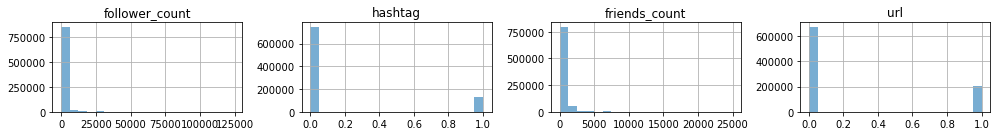

In [11]:
# plotting histograms to have the distribution of the different features

columns = clusters.columns

fig, axs = plt.subplots(1, len(columns), figsize=(14,2), sharex=False)

for column_idx in range(0, len(columns)):
    clusters[columns[column_idx]].hist(bins=20, ax=axs[column_idx], alpha=0.6)
    axs[column_idx].set_title(columns[column_idx])
    
plt.tight_layout()

In [12]:
scaled_features = StandardScaler().fit(clusters_test).transform(clusters_test)
print("Scaled sample: %s" %scaled_features[0])

Scaled sample: [-0.17102204 -0.41774821 -0.27467711 -0.5498574 ]


In [15]:
scaled_features = StandardScaler().fit(clusters_test).transform(clusters_test)
print("Scaled sample: %s" %scaled_features[0])

Scaled sample: [-0.17102204 -0.27467711]


##### Elbow test

In [16]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")


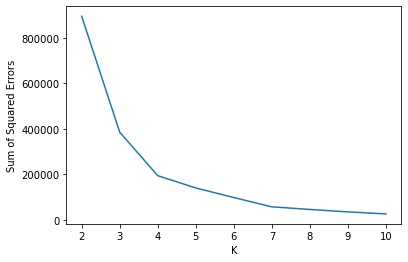

In [17]:
plot_sse(scaled_features)

In [ ]:
' elbow test underlining that the optimal number of clusters is 5'

In [21]:
labels = KMeans(n_clusters=8, random_state=0).fit_predict(scaled_features)

In [22]:
# adding the cluster in the data

cluster['groupe'] = labels

<ipython-input-22-38acd09f55e9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['groupe'] = labels


##### standard deviation of clusters

In [23]:
standard = np.zeros(5)
longueur = np.zeros(5)

for i in range (5):
    groupe = cluster[(cluster['groupe'] == i)]
    standard[i] = groupe['retweet_count'].std()
    longueur[i] = len(groupe['retweet_count'])
    
print(standard, longueur)

[ 4.00614998 46.93512147  0.33728684  5.44536889 24.9776017 ] [744013.   2400.   1289.   9452.   2676.]


##### standard deviation of data

In [18]:
cluster['retweet_count'].std()

7.21324594997515

In [35]:
clusters_test

,follower_count,friends_count,retweet_count
85,65.0,118.0,0
86,65.0,118.0,0
89,65.0,118.0,0
90,65.0,118.0,0
91,65.0,118.0,0
...,...,...,...
4702006,194.0,95.0,4
4702007,194.0,95.0,0
4702017,194.0,95.0,0
4702021,194.0,95.0,0


In [42]:
full_data = clusters_test.loc[clusters_test.retweet_count!=0].copy()

stock_cluster =[]
pred=[]
cluster_new = []

nb_cluster = 2
N = len(data)
while  len(full_data) > 0.3*N:
    data = full_data[['follower_count','friends_count']].copy()
    data_norm = pd.DataFrame(StandardScaler().fit(data).transform(data))
    groupe = KMeans(n_clusters = nb_cluster, random_state=42).fit_predict(data_norm)
    full_data['groupe'] = pd.DataFrame(groupe)
    standard = np.zeros(nb_cluster)
    
    for i in range (nb_cluster):
        groupe = full_data[(full_data['groupe'] == i)]
        
        print(groupe['retweet_count'].std(), groupe['retweet_count'].mean())
        if standard[i] < groupe['retweet_count'].mean():
            
            pred.append(groupe)
            full_data=full_data[(full_data['groupe'] != i)]
            print(len(full_data))
            nb_cluster=2
            get array (56 and.numpy(pqtricepetitclqir))
        
        
    nb_cluster=2
    print(nb_cluster, len(full_data))

1.118190346206606 1.3636363636363635
88840
1.6243961216415885 1.6672077922077921
88224
3 88224
nan nan
nan nan
nan nan
4 88224
nan nan
nan nan
nan nan
nan nan
5 88224
nan nan
nan nan
nan nan
nan nan
nan nan
6 88224
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
7 88224
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
8 88224
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
9 88224
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
10 88224
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
11 88224
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
12 88224
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
13 88224
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
14 88224
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan 

KeyboardInterrupt: 

In [ ]:
''' some clusters are less precise (higher standard deviation), so the clustering is not really efficient '''

# TD applied ML: regression

In [ ]:
'''
trying regression on the data, without cluster because they are not really precise
'''

In [20]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [ ]:
'''
regression without the date information
'''

In [21]:
regression = cluster[['follower_count','hashtag','retweet_count', 'friends_count', 'url']]

In [22]:
[train, test] = split_set(regression)

In [23]:
train_label=train.retweet_count
train_features = train.drop('retweet_count', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test.retweet_count
test_features = test.drop('retweet_count', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 704770
Length of the test dataset : 175515


In [24]:
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

train_features_std.head()

,follower_count,hashtag,friends_count,url
0,-0.170259,-0.418267,-0.274296,-0.549803
1,-0.170259,2.390813,-0.274296,-0.549803
2,-0.170259,-0.418267,-0.274296,-0.549803
3,-0.170259,2.390813,-0.274296,-0.549803
4,-0.170259,-0.418267,-0.274296,-0.549803


In [ ]:
'''
expliquer pourquoi on fait ça !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
'''

In [25]:
lin_reg1 = LinearRegression()  # create the model


y_train1=train.retweet_count
y_test1=test.retweet_count
lin_reg1.fit(train_features_std,y_train1) # train

# R² obtained
score1=lin_reg1.score(test_features_std, y_test1)

print('R² equal %f'%(score1))

R² equal 0.009048


In [26]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(train_features_std, y_train1)
reg.score(test_features_std, y_test1)

0.12502059133662857

In [ ]:
'''
commenter les valeurs !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
'''

### regression with date

In [27]:
# The egos are isolated, we work only with the True ego
ego_true = profiles[profiles['IsEgo']==True]

# converting Nan into -1
ego_bis = ego_true.fillna(-1)


# looking for utc_offset lines with Nan, protected ego and no statusescount 

lines = []

for i in range (len(ego_bis)):
    if ego_bis.iloc[i][5] == -1  or ego_bis.iloc[i][8] or ego_bis.iloc[i][4] == 0.0:
        lines.append(i)
        
# removing those lines      
ego_reduced = ego_bis.drop(ego_bis.index[lines])

# stocking the ego_id values that we will use
ego_id = np.array(ego_reduced['ID'])

In [28]:
# translating the seconds of utc_offet into nanosecondes
ego_bis["utc_offset"] = ego_bis["utc_offset"]*1000000000


# stocking in column offset and removing the sign of utc_offset with .abs() 
# to be allow to convert utc_offset into datetime and then keep only the hour information from a datetime

offset = []
for i in range (len(ego_bis)):
    
    if ego_bis.iloc[i][5] >= 0:
        offset.append(1)
    else:
        offset.append(-1)

ego_bis["offset"] = offset
ego_bis["utc_offset"] = ego_bis["utc_offset"].abs()

ego_bis["utc_offset"] = pd.to_datetime(ego_bis["utc_offset"]) 

# hour like 16:54:33 into 16
ego_bis["utc_offset"] = ego_bis.utc_offset.dt.hour

In [29]:
linetimelines = []

for i in range (len(timelines)):
    
    if timelines.iloc[i][9] not in ego_id:
        linetimelines.append(i)

timelines_reduced = timelines.drop(timelines.index[linetimelines])

In [30]:
timelines_reduced[['Day','Month', 'Date', 'Hour', 'Se', 'Year']] = timelines_reduced.created_at.str.split(" ",expand=True,)


In [31]:
# as explained above we only deal with the 2014 tweets

time_reduced = timelines_reduced[(timelines_reduced['Year'] == '2014')]

In [32]:
time=time_reduced.loc[time_reduced.mentions_ids==0]
time=time.loc[time.replytoUserID==0]
time=time.loc[time.retweetedUserID==0]

In [33]:
# converting 'hour' into datetime and shortening to only have the hour: for instance 16:57:31 becomes 16
time["Hour"] = pd.to_datetime(time["Hour"]) 
time["Hour"] = time.Hour.dt.hour

In [34]:
hour_new = []
Days = []

for i in range (len(time)):
    a = time.iloc[i][9]
    
    # adding the offset depending on his value and sign
    b = time.iloc[i][18] + ego_bis.iloc[a-1][5]*ego_bis.iloc[a-1][9]
    
    if b < 0:
    # so we have to go back for 1 day
        hour_new.append(b+24)
        if time.iloc[i][15] == 'Mon':
            Days.append('Sun')
        if time.iloc[i][15] == 'Tue':
            Days.append('Mon')
        if time.iloc[i][15] == 'Wed':
            Days.append('Tue')
        if time.iloc[i][15] == 'Thu':
            Days.append('Wed')
        if time.iloc[i][15] == 'Fri':
            Days.append('Thu')
        if time.iloc[i][15] == 'Sat':
            Days.append('Fri')
        if time.iloc[i][15] == 'Sun':
            Days.append('Sat')
    
    elif b >= 24:
    # we have to go ahead for 1 day
        hour_new.append(b-24)
        if time.iloc[i][15] == 'Mon':
            Days.append('Tue')
        if time.iloc[i][15] == 'Tue':
            Days.append('Wed')
        if time.iloc[i][15] == 'Wed':
            Days.append('Thu')
        if time.iloc[i][15] == 'Thu':
            Days.append('Fri')
        if time.iloc[i][15] == 'Fri':
            Days.append('Sat')
        if time.iloc[i][15] == 'Sat':
            Days.append('Sun')
        if time.iloc[i][15] == 'Sun':
            Days.append('Mon')
    else:
        hour_new.append(b)
        Days.append(time.iloc[i][15])


In [35]:
time['newhour'] = hour_new
time['days'] = Days

In [36]:
regression_date = time[['follower_count','friends_count', 'retweet_count', 'hashtags', 'urls','days', 'newhour', 'Month']]

# converting url and hashtag into numbers

hashtag = np.zeros(len(regression_date))
url = np.zeros(len(regression_date))

for i in (range(len(regression_date))):
    if regression_date.urls.iloc[i] == 0:
        url[i] = 0
    else:
        url[i] = 1
        
    if regression_date.hashtags.iloc[i] == 0:
        hashtag[i] = 0
    else:
        hashtag[i] = 1   

regression_date['url'] = url
regression_date['hashtag'] = hashtag

<ipython-input-36-43f815df382c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_date['url'] = url
<ipython-input-36-43f815df382c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_date['hashtag'] = hashtag


In [133]:
regression_date_bis = regression_date[['follower_count','friends_count', 'retweet_count', 'hashtag', 'url','days', 'newhour','Month']]

In [134]:
[train2, test2] = split_set(regression_date_bis)

##### converting object like months and days into numbers

In [135]:
categorical2_columns = ['days','Month']
train2_categorical = pd.get_dummies(train2, columns=categorical2_columns)
train2_categorical.head()

,follower_count,friends_count,retweet_count,hashtag,url,newhour,days_Fri,days_Mon,days_Sat,days_Sun,...,Month_Apr,Month_Aug,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Oct,Month_Sep
0,14.0,21.0,0,0.0,0.0,18,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,14.0,21.0,0,0.0,0.0,18,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,14.0,21.0,0,0.0,0.0,15,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,14.0,21.0,0,1.0,0.0,15,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,14.0,21.0,0,0.0,0.0,10,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [136]:
test2_categorical = pd.get_dummies(test2, columns=categorical2_columns)[train2_categorical.columns]

#### regression

In [137]:
train2_label=train2_categorical.retweet_count
train2_features = train2_categorical.drop('retweet_count', axis=1)
print('Length of the train dataset : {}'.format(len(train2)))

test2_label=test2_categorical.retweet_count
test2_features = test2_categorical.drop('retweet_count', axis=1)
print('Length of the test dataset : {}'.format(len(test2)))

Length of the train dataset : 437790
Length of the test dataset : 109573


In [138]:
means = train2_features.mean()
stddevs = train2_features.std()

train2_features_std = pd.DataFrame()
for c in train2_features.columns:
    train2_features_std[c] = (train2_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test2_features_std = pd.DataFrame()
for c in test2_features.columns:
    test2_features_std[c] = (test2_features[c]-means[c])/stddevs[c]

train2_features_std.head()

,follower_count,friends_count,hashtag,url,newhour,days_Fri,days_Mon,days_Sat,days_Sun,days_Thu,...,Month_Apr,Month_Aug,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Oct,Month_Sep
0,-0.192656,-0.322888,-0.404182,-0.557659,0.632901,-0.400642,2.446554,-0.400688,-0.42077,-0.413040,...,3.259425,-0.364731,-0.274898,-0.294503,-0.35974,-0.327866,-0.305414,-0.325974,-0.397546,-0.364003
1,-0.192656,-0.322888,-0.404182,-0.557659,0.632901,-0.400642,-0.408737,2.495704,-0.42077,-0.413040,...,3.259425,-0.364731,-0.274898,-0.294503,-0.35974,-0.327866,-0.305414,-0.325974,-0.397546,-0.364003
2,-0.192656,-0.322888,-0.404182,-0.557659,0.204960,-0.400642,-0.408737,-0.400688,-0.42077,2.421069,...,-0.306802,-0.364731,3.637702,-0.294503,-0.35974,-0.327866,-0.305414,-0.325974,-0.397546,-0.364003
3,-0.192656,-0.322888,2.474126,-0.557659,0.204960,-0.400642,-0.408737,-0.400688,2.37659,-0.413040,...,-0.306802,-0.364731,-0.274898,-0.294503,-0.35974,-0.327866,-0.305414,-0.325974,2.515429,-0.364003
4,-0.192656,-0.322888,-0.404182,-0.557659,-0.508276,-0.400642,-0.408737,2.495704,-0.42077,-0.413040,...,-0.306802,-0.364731,-0.274898,-0.294503,-0.35974,-0.327866,-0.305414,-0.325974,-0.397546,2.747222


In [139]:
lin_reg1 = LinearRegression()  # create the model


y_train2=train2.retweet_count
y_test2=test2.retweet_count
lin_reg1.fit(train2_features_std,y_train2) # train

# R² obtained
score2=lin_reg1.score(test2_features_std, y_test2)

print('R² equal %f'%(score2))

R² equal 0.007961


In [140]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(train2_features_std, y_train2)
reg.score(test2_features_std, y_test2)

0.7836850581256467

### création des clusters sans heure ni jour

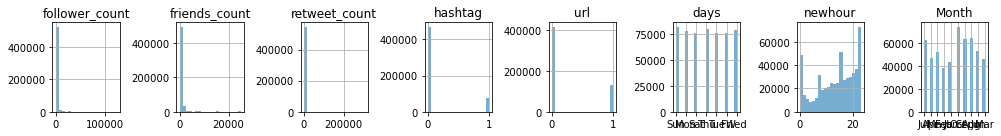

In [141]:
columns = regression_date_bis.columns

fig, axs = plt.subplots(1, len(columns), figsize=(14,2), sharex=False)

for column_idx in range(0, len(columns)):
    regression_date_bis[columns[column_idx]].hist(bins=20, ax=axs[column_idx], alpha=0.6)
    axs[column_idx].set_title(columns[column_idx])
    
plt.tight_layout()

In [142]:
cluster_bis = regression_date_bis[['follower_count', 'friends_count', 'hashtag', 'url']]

In [143]:
scaled2_features = StandardScaler().fit(cluster_bis).transform(cluster_bis)
print("Scaled sample: %s" %scaled2_features[0])

Scaled sample: [-0.19347984 -0.32322343 -0.40393902 -0.55718567]


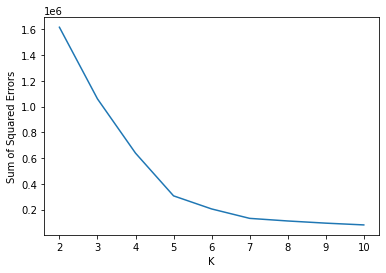

In [144]:
plot_sse(scaled2_features)

In [145]:
labels = KMeans(n_clusters=5, random_state=42).fit_predict(scaled2_features)

In [146]:
regression_date_bis['groupe'] = labels

<ipython-input-146-11a823f25489>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_date_bis['groupe'] = labels


In [147]:
standard = np.zeros(5)
longueur = np.zeros(5)

for i in range (5):
    groupe = regression_date_bis[(regression_date_bis['groupe'] == i)]
    standard[i] = groupe['retweet_count'].std()
    longueur[i] = len(groupe['retweet_count'])
    
print(standard, longueur)

[1789.39114812  332.57572597   80.82327142 2271.76987442   41.29818248] [ 95887. 368503.   1298.  75751.   5924.]


In [148]:
regression_date_bis['retweet_count'].std()

1164.6318535444243

In [ ]:
'''
clusters 0 et 3 nuls
'''

In [149]:
reg_cluster = regression_date_bis[['follower_count', 'friends_count', 'retweet_count', 'hashtag', 'url','days', 'groupe']]

### regression sur les clusters: cluster 4 ici, sans Month car moins précis avec, newhour pas utilisée car soit moins précis avec soit certaines heures ne sont pas dans train ou test

In [150]:
[train3, test3] = split_set(reg_cluster[(reg_cluster['groupe'] == 4)])

train3 = train3.drop('groupe', axis=1)
test3 = test3.drop('groupe', axis=1)

'''
# drop url car dans ce cluster personne n'a de url et hashtag
train3 = train3.drop('url', axis=1)
test3 = test3.drop('url', axis=1)

train3 = train3.drop('hashtag', axis=1)
test3 = test3.drop('hashtag', axis=1)
'''

"\n# drop url car dans ce cluster personne n'a de url et hashtag\ntrain3 = train3.drop('url', axis=1)\ntest3 = test3.drop('url', axis=1)\n\ntrain3 = train3.drop('hashtag', axis=1)\ntest3 = test3.drop('hashtag', axis=1)\n"

In [151]:
categorical3_columns = ['days']
train3_categorical = pd.get_dummies(train3, columns=categorical3_columns)

test3_categorical = pd.get_dummies(test3 ,columns=categorical3_columns)[train3_categorical.columns]

In [152]:
test3_label = test3_categorical.retweet_count
test3_features = test3_categorical.drop('retweet_count', axis=1)

train3_label = train3_categorical.retweet_count
train3_features = train3_categorical.drop('retweet_count', axis=1)

means = train3_features.mean()
stddevs = train3_features.std()

train3_features_std = pd.DataFrame()
for c in train3_features.columns:
    train3_features_std[c] = (train3_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test3_features_std = pd.DataFrame()
for c in test3_features.columns:
    test3_features_std[c] = (test3_features[c]-means[c])/stddevs[c]
    
y_train3 = train3.retweet_count
y_test3 = test3.retweet_count

In [153]:
train3_features_std

,follower_count,friends_count,hashtag,url,days_Fri,days_Mon,days_Sat,days_Sun,days_Thu,days_Tue,days_Wed
0,-1.285711,-1.277149,2.293841,1.101545,-0.452112,2.707514,-0.423180,-0.374746,-0.406856,-0.408255,-0.42042
1,-1.285711,-1.277149,-0.435858,1.101545,-0.452112,2.707514,-0.423180,-0.374746,-0.406856,-0.408255,-0.42042
2,-1.285711,-1.277149,-0.435858,-0.907626,-0.452112,-0.369265,2.362562,-0.374746,-0.406856,-0.408255,-0.42042
3,-1.285711,-1.277149,-0.435858,1.101545,-0.452112,-0.369265,2.362562,-0.374746,-0.406856,-0.408255,-0.42042
4,-1.285711,-1.277149,-0.435858,1.101545,-0.452112,-0.369265,2.362562,-0.374746,-0.406856,-0.408255,-0.42042
...,...,...,...,...,...,...,...,...,...,...,...
4761,0.946438,1.096084,-0.435858,1.101545,-0.452112,-0.369265,-0.423180,-0.374746,-0.406856,2.448933,-0.42042
4762,0.946438,1.096084,-0.435858,1.101545,-0.452112,-0.369265,-0.423180,-0.374746,-0.406856,2.448933,-0.42042
4763,0.946438,1.096084,-0.435858,1.101545,-0.452112,-0.369265,-0.423180,-0.374746,-0.406856,2.448933,-0.42042
4764,0.946438,1.096084,-0.435858,1.101545,-0.452112,-0.369265,-0.423180,-0.374746,-0.406856,2.448933,-0.42042


In [154]:
lin_reg1.fit(train3_features_std,y_train3) # train

# R² obtained
score3=lin_reg1.score(test3_features_std, y_test3)

print('R² equal %f'%(score3))

R² equal 0.036585


In [155]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(train3_features_std, y_train3)
reg.score(test3_features_std, y_test3)

0.03977501341039125

In [ ]:
'''
pb des clusters: nul parce que certains ont une plus grande standard deviation que la data
pb de 1 seul ego dedans aussi
pb de certaines horaires qu'on ne retoruve pas
moins précis sur des clusters
'''

### cluster avec date

In [156]:
regression2_date = regression_date_bis

In [157]:
cluster_ter = regression2_date[['follower_count', 'friends_count', 'hashtag', 'url', 'newhour', 'days']]

In [158]:
categorical4_columns = ['days']
cluster_ter2 = pd.get_dummies(cluster_ter, columns=categorical4_columns)


In [159]:
scaled3_features = StandardScaler().fit(cluster_ter2).transform(cluster_ter2)
print("Scaled sample: %s" %scaled3_features[0])

Scaled sample: [-0.19347984 -0.32322343 -0.40393902 -0.55718567 -0.08028665 -0.40100936
 -0.40920802 -0.40072693  2.37733365 -0.41263691 -0.40315849 -0.41019632]


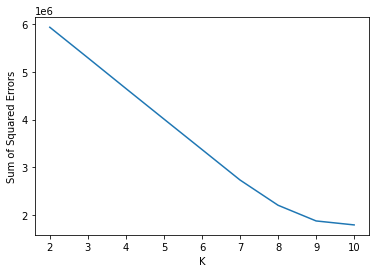

In [160]:
plot_sse(scaled3_features)

In [161]:
labels2 = KMeans(n_clusters=9, random_state=42).fit_predict(scaled3_features)

In [168]:
regression2_date['groupe'] = labels2

<ipython-input-168-385e5c1da83c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression2_date['groupe'] = labels2


In [169]:
standard = np.zeros(9)
longueur = np.zeros(9)

for i in range (9):
    groupe = regression2_date[(regression2_date['groupe'] == i)]
    standard[i] = groupe['retweet_count'].std()
    longueur[i] = len(groupe['retweet_count'])
    
print(standard, longueur)

[1713.32821159 1350.63699253  856.4116176   925.82682406  765.96349418
  811.52244709 1420.18638571   41.29818248   80.82327142] [77776. 78546. 77671. 81404. 74669. 75420. 74655.  5924.  1298.]


In [170]:
regression2_date['retweet_count'].std()

1164.6318535444243

In [ ]:
'''
certains clusters ont l'air intéressants
'''

In [171]:
regression2_date.head()

,follower_count,friends_count,retweet_count,hashtag,url,days,newhour,Month,groupe
3216,14.0,21.0,0,0.0,0.0,Sun,13,Jul,3
3217,14.0,21.0,0,0.0,0.0,Mon,18,Apr,2
3218,14.0,21.0,1,0.0,0.0,Sat,13,May,4
3219,14.0,21.0,0,0.0,0.0,Sat,18,Apr,4
3220,14.0,21.0,0,0.0,0.0,Thu,15,Feb,1


In [172]:
reg2_cluster = regression2_date[['follower_count', 'friends_count', 'retweet_count', 'hashtag', 'url','days', 'groupe']]

In [173]:
[train4, test4] = split_set(reg2_cluster[(reg2_cluster['groupe'] == 7)])

train4 = train4.drop('groupe', axis=1)
test4 = test4.drop('groupe', axis=1)

'''
# drop url car dans ce cluster personne n'a de url et hashtag
train3 = train3.drop('url', axis=1)
test3 = test3.drop('url', axis=1)

train3 = train3.drop('hashtag', axis=1)
test3 = test3.drop('hashtag', axis=1)
'''

"\n# drop url car dans ce cluster personne n'a de url et hashtag\ntrain3 = train3.drop('url', axis=1)\ntest3 = test3.drop('url', axis=1)\n\ntrain3 = train3.drop('hashtag', axis=1)\ntest3 = test3.drop('hashtag', axis=1)\n"

In [174]:
categorical5_columns = ['days']
train4_categorical = pd.get_dummies(train4, columns=categorical5_columns)

test4_categorical = pd.get_dummies(test4 ,columns=categorical5_columns)[train4_categorical.columns]

In [175]:
test4_label = test4_categorical.retweet_count
test4_features = test4_categorical.drop('retweet_count', axis=1)

train4_label = train4_categorical.retweet_count
train4_features = train4_categorical.drop('retweet_count', axis=1)

means = train4_features.mean()
stddevs = train4_features.std()

train4_features_std = pd.DataFrame()
for c in train4_features.columns:
    train4_features_std[c] = (train4_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test4_features_std = pd.DataFrame()
for c in test4_features.columns:
    test4_features_std[c] = (test4_features[c]-means[c])/stddevs[c]
    
y_train4 = train4.retweet_count
y_test4 = test4.retweet_count

In [176]:
train4_features_std

,follower_count,friends_count,hashtag,url,days_Fri,days_Mon,days_Sat,days_Sun,days_Thu,days_Tue,days_Wed
0,-1.283599,-1.277122,2.365365,1.086905,-0.458317,2.703115,-0.422334,-0.373519,-0.401792,-0.405305,-0.423368
1,-1.283599,-1.277122,-0.422679,1.086905,-0.458317,2.703115,-0.422334,-0.373519,-0.401792,-0.405305,-0.423368
2,-1.283599,-1.277122,-0.422679,-0.919851,-0.458317,-0.369866,2.367295,-0.373519,-0.401792,-0.405305,-0.423368
3,-1.283599,-1.277122,-0.422679,1.086905,-0.458317,-0.369866,2.367295,-0.373519,-0.401792,-0.405305,-0.423368
4,-1.283599,-1.277122,-0.422679,1.086905,-0.458317,-0.369866,2.367295,-0.373519,-0.401792,-0.405305,-0.423368
...,...,...,...,...,...,...,...,...,...,...,...
4764,0.941053,1.093223,-0.422679,1.086905,-0.458317,-0.369866,-0.422334,-0.373519,-0.401792,2.466760,-0.423368
4765,0.941053,1.093223,-0.422679,1.086905,-0.458317,-0.369866,-0.422334,-0.373519,-0.401792,2.466760,-0.423368
4766,0.941053,1.093223,-0.422679,1.086905,-0.458317,-0.369866,-0.422334,-0.373519,-0.401792,2.466760,-0.423368
4767,0.941053,1.093223,-0.422679,1.086905,-0.458317,-0.369866,-0.422334,-0.373519,-0.401792,2.466760,-0.423368


In [177]:
lin_reg1.fit(train4_features_std,y_train4) # train

# R² obtained
score4=lin_reg1.score(test4_features_std, y_test4)

print('R² equal %f'%(score4))

R² equal 0.028686


In [178]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(train4_features_std, y_train4)
reg.score(test4_features_std, y_test4)

0.03287040243424655

In [ ]:
'''
donc cluster avec tous c'est nul
'''